##############################################################################################
Conceptos y repaso de un systema de fibra optica 1.5
##############################################################################################

Created on Fri May 15 20:01:28 2021

Conceptos y repaso de un sistema de fibra optica

@author: Diego Villafani

Amplificador EDFA


In [1]:
#Comenzaremos con la modulacion del Laser con OOK

#Primero Importamos las librerias necesarias
import numpy as np
import matplotlib.pyplot as plt


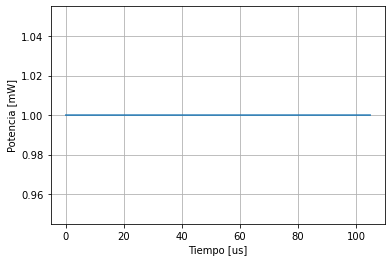

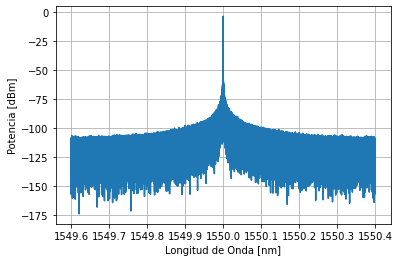

In [2]:
#Primero Generamos nuevamente el Laser simulado anteriormente.

#En la realidad, un laser en 1550nm es parecido con una señal senoidal, la cual oscila 
#a f=c/1550nm donde c es la velocidad de la luz en el vacio.
#En esta simulacion, consideramos que nuestro punto de referencia de la frequencua, la frequencia = 0,  es f=c/1550nm
# El Laser simulado estara en el espectro electromagnetico al rededor de 1550nm.
#Debemos entender que en esta simulación, utilizaremos la señal en banda base y asumimos que el laser esta en
#banda base.

Longitud_de_onda_del_laser_central=1550e-9 #Longitud de Onda en metros e-9 =nm

Potencia_dBm= 0 #Potencia en dBm

Sintonizar_Laser=0e9  #Sintonizar Laser respecto a 1550nm en Hz

#Creando Los parametros para la simulacion 
Potencia_mw=10**(Potencia_dBm/10)   #Potencia en mW
c  = 2.99792458e8                   #Velocidad de la luz
Frequencia_del_laser=c/Longitud_de_onda_del_laser_central    #Frequencia del Laser en Hz
frequencia_de_muestreo=2*50e9 #Span del OSA o rango de frequencias donde veremos la señal
numero_de_muestras=2**21

dt_samp=1/frequencia_de_muestreo #Delta del tiempo entre muestras

Tiempo_total=dt_samp*numero_de_muestras #Tiempo Total

Vector_tiempo=np.arange(0,(numero_de_muestras)*dt_samp,dt_samp) #Vector del Tiempo

Vector_frequencia=Frequencia_del_laser+(1/Tiempo_total)*np.arange(-numero_de_muestras/2,numero_de_muestras/2,1) #Vector de la frequencia

Vector_Longitud_de_onda=c/Vector_frequencia



#Creando el laser simulado

Laser_CW=np.sqrt(Potencia_mw*np.ones(numero_de_muestras)) #Laser CW= constant Wave

#Phase noise
varianza_de_fase = 2*np.pi*(100e3)*dt_samp 
fase_con_ruido=np.cumsum(np.sqrt(varianza_de_fase)*np.random.randn(numero_de_muestras))

#Laser Simulado en el tiempo
Laser=Laser_CW*np.exp(1j*2*np.pi*Sintonizar_Laser*Vector_tiempo+1j*fase_con_ruido)

#Convirtiendo la señal del tiempo a frequencia con FFT

Espectro=(np.abs(np.sqrt(dt_samp/numero_de_muestras)*np.fft.fft(Laser))**2)*(1/Tiempo_total)
Espectro_fft=np.append(Espectro[int(numero_de_muestras/2):numero_de_muestras],Espectro[0:int(numero_de_muestras/2)])


#Graficando el laser continuo en el tiempo
plt.grid(True)
plt.plot(Vector_tiempo*10e6,(np.abs(Laser)**2))
plt.ticklabel_format(useOffset=False)
plt.ylabel('Potencia [mW]')
plt.xlabel('Tiempo [us]')
plt.show()

#Graficando el espectro
plt.grid(True)
#plt.plot(Vector_frequencia/1e12,10*np.log10(Espectro_fft))
plt.plot(Vector_Longitud_de_onda*1e9,10*np.log10(Espectro_fft))
plt.ticklabel_format(useOffset=False)
plt.ylabel('Potencia [dBm]')
plt.xlabel('Longitud de Onda [nm]')
plt.show()




In [3]:
#Potencia total:
P_mean = np.mean(np.abs(Laser)**2)
10*np.log10(P_mean)

0.0

bits =[0. 0. 1. ... 1. 0. 0.]


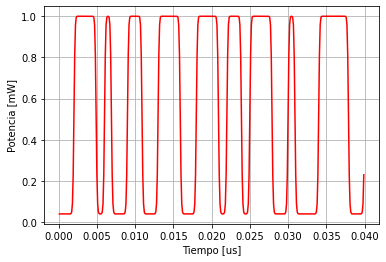

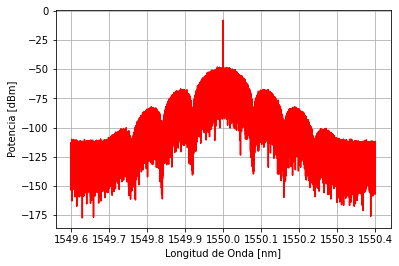

In [4]:
#Modulando el Laser

#Utilizamos la señal generada anteriormente de bits digitales

#Parametros de la señal
Amplitud_bit_1=1 #Amplitud
Tasa_de_transmission=10e9 #Tasa de transmision en bits por segundo

#Calculamos el Extinction ratio
Extinction_ratio=7 #dB 10*log10(amp_nivel_1/amp_nivel0)
level_0=1/(10**(Extinction_ratio/10));

#Numero total de bits para el tiempo graficado
numero_de_bits=np.around(Tiempo_total/(1/Tasa_de_transmission))

#Bits aleatorios
bits=np.random.randint(2, size=int(numero_de_bits)).astype('float')
print("bits =" +str(bits))

#Creando la señal
Vector_Señal=Amplitud_bit_1*bits.repeat(np.ceil(numero_de_muestras/len(bits)), axis=0)
Vector_Señal[Vector_Señal < 0.5] = level_0


#Filtramos simulando el filtro electrico
bandwidth = 0.8*Tasa_de_transmission  # Electrical Filter bandwidth [Hz]

#Filtro gausiano centrado en 0
df = 2*bandwidth/np.sqrt(2*np.log(2)) #3dB FWHM
Vector_frequencia_0=Vector_frequencia-Frequencia_del_laser
Hf = np.fft.fftshift(np.exp(-((Vector_frequencia_0)**2)/(df**2)))

Vector_Señal=np.fft.ifft(np.fft.fft(Vector_Señal[0:len(Hf)])*Hf)


#Agregamos ruido
noise = np.random.normal(0, 0.01, Vector_Señal.shape)
Vector_Señal = Vector_Señal + noise


#Laser Simulado en el tiempo
Laser_mod=Laser*Vector_Señal[0:len(Laser)]

#Convirtiendo la señal del tiempo a frequencia con FFT

Espectro=(np.abs(np.sqrt(dt_samp/numero_de_muestras)*np.fft.fft(Laser_mod))**2)*(1/Tiempo_total)
Espectro_fft=np.append(Espectro[int(numero_de_muestras/2):numero_de_muestras],Espectro[0:int(numero_de_muestras/2)])


#Graficando parte del laser modulado en el tiempo
plt.grid(True)
plt.plot(Vector_tiempo[1:int(Tasa_de_transmission/1e9*40)]*10e6,np.abs(Laser_mod[1:int(Tasa_de_transmission/1e9*40)])**2, color='red')
plt.ylabel('Potencia [mW]')
plt.xlabel('Tiempo [us]')
plt.show()

#Graficando el espectro
plt.grid(True)
#plt.plot(Vector_frequencia/1e12,10*np.log10(Espectro_fft))
plt.plot(Vector_Longitud_de_onda*1e9,10*np.log10(Espectro_fft), color='red')
plt.ticklabel_format(useOffset=False)
plt.ylabel('Potencia [dBm]')
plt.xlabel('Longitud de Onda [nm]')
plt.show()


In [5]:
#Potencia total:
P_mean = np.mean(np.abs(Laser_mod)**2)
10*np.log10(P_mean)

-3.0489506874312804

OSNR=66.48884126670488


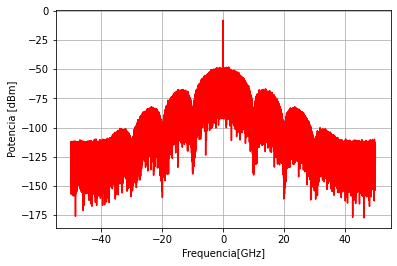

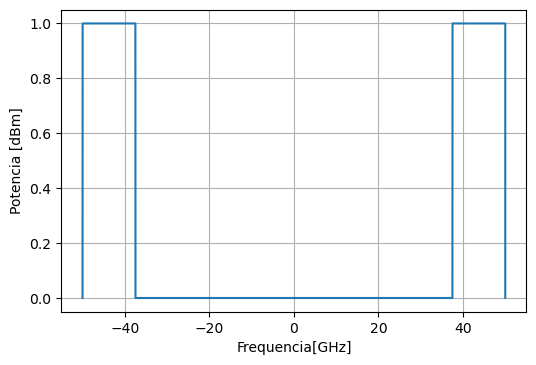

In [6]:
#Filtering Noise
df=12.5e9 #3dB BW [Hz]
f0_i=Vector_frequencia_0[0]+12.5e9/2 #Frequencia central del filtro izquierda[Hz]
f0_d=Vector_frequencia_0[-1]-12.5e9/2 #Frequencia central del filtro derecha[Hz]



Hfi= 1*(abs(Vector_frequencia_0-f0_i)<df/2)
Hfd= 1*(abs(Vector_frequencia_0-f0_d)<df/2)

Hf=Hfd+Hfi

Noise=np.fft.ifft(np.fft.fftshift(np.fft.fft(Laser_mod))*Hf)
P_noise_mean = np.mean(np.abs(Noise)**2)/2
#10*np.log10(P_noise_mean)


osnr=10*np.log10((P_mean-P_noise_mean*((Vector_frequencia_0[-1]-Vector_frequencia_0[0])/12.5e9))/P_noise_mean);

print('OSNR='+str(osnr))

#Graficando el espectro Señal
plt.grid(True)
#plt.plot(Vector_frequencia/1e12,10*np.log10(Espectro_fft))
plt.plot(Vector_frequencia_0/1e9,10*np.log10(Espectro_fft), color='red')
plt.ticklabel_format(useOffset=False)
plt.ylabel('Potencia [dBm]')
plt.xlabel('Frequencia[GHz]')
plt.show()

#Graficando el espectro filtro
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.grid(True)
plt.plot(Vector_frequencia_0/1e9,Hf)
plt.ticklabel_format(useOffset=False)
plt.ylabel('Potencia [dBm]')
plt.xlabel('Frequencia[GHz]')
plt.show()


OSNR=27.909691561134792


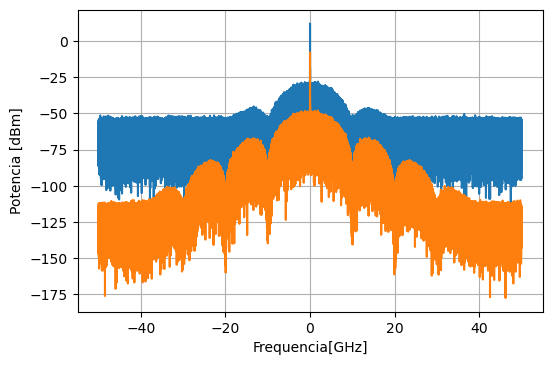

In [7]:
# Amplifier Noise and Amplification
NoiseFigure=30 #dB
Fn = 10**(NoiseFigure/10); # Noise figure linear

Gain=20 #Ganancia dB
G = 10**(Gain/10) # Ganancia linear

#Amplificacion sin ruido

Laser_mod_amp = np.sqrt(G)*Laser_mod


#Ruido
h   = 6.626076e-34 # Planck's constant [Js]
BW  = 1/dt_samp;   # Bandwidth ode la senal

S   = G*Fn*h*Frequencia_del_laser*1e3/2 # Power spectral density, [mW/Hz]

P_n = S*BW #Potencia del Ruido

# Creamos el ruido blanco en una señal compleja

u_n = (np.sqrt(P_n)/np.sqrt(2))*(np.random.randn(len(Laser_mod_amp)) + 1j*np.random.randn(len(Laser_mod_amp)))

#Agregamos el ruido a nuestra señal

Laser_mod_ruido = Laser_mod_amp + u_n;


Espectro_n=(np.abs(np.sqrt(dt_samp/numero_de_muestras)*np.fft.fft(Laser_mod_ruido))**2)*(1/Tiempo_total)
Espectro_fft_n=np.append(Espectro_n[int(numero_de_muestras/2):numero_de_muestras],Espectro_n[0:int(numero_de_muestras/2)])

#Medimos el OSNR
#Potencia total:
P_mean2 = np.mean(np.abs(Laser_mod_ruido)**2)

Noise2=np.fft.ifft(np.fft.fftshift(np.fft.fft(Laser_mod_ruido))*Hf)
P_noise_mean2 = np.mean(np.abs(Noise2)**2)/2


osnr2=10*np.log10((P_mean2-P_noise_mean2*((Vector_frequencia_0[-1]-Vector_frequencia_0[0])/12.5e9))/P_noise_mean2);

print('OSNR='+str(osnr2))

#Graficando el espectro Señal
plt.grid(True)
#plt.plot(Vector_frequencia/1e12,10*np.log10(Espectro_fft))
plt.plot(Vector_frequencia_0/1e9,10*np.log10(Espectro_fft_n),Vector_frequencia_0/1e9,10*np.log10(Espectro_fft))
plt.ticklabel_format(useOffset=False)
plt.ylabel('Potencia [dBm]')
plt.xlabel('Frequencia[GHz]')
plt.show()

OSNR=34.92101652556449
Rx Power= -3.04dBm BER =0.0
OSNR=31.89909925644689
Rx Power= -3.03dBm BER =0.0
OSNR=30.131432274148807
Rx Power= -3.02dBm BER =0.0
OSNR=28.88306711473777
Rx Power= -3.0dBm BER =0.0
OSNR=27.912631737229383
Rx Power= -2.99dBm BER =0.0
OSNR=27.124752334813955
Rx Power= -2.98dBm BER =0.0
OSNR=26.457220118604667
Rx Power= -2.97dBm BER =9.536797734056858e-06
OSNR=25.892029185494167
Rx Power= -2.96dBm BER =3.814719093622743e-05
OSNR=25.376730453329714
Rx Power= -2.95dBm BER =4.768398867028429e-05
OSNR=24.915398068121604
Rx Power= -2.94dBm BER =8.583117960651172e-05
OSNR=24.498594619426285
Rx Power= -2.93dBm BER =0.00014305196601085288
OSNR=24.124711567882077
Rx Power= -2.92dBm BER =0.0002288831456173646
OSNR=23.774125303292838
Rx Power= -2.9dBm BER =0.00040054550483038803
OSNR=23.449736939886584
Rx Power= -2.89dBm BER =0.0006008182572455821
OSNR=23.14276852600701
Rx Power= -2.88dBm BER =0.0009346061779375722
OSNR=22.86092178760251
Rx Power= -2.87dBm BER =0.0012683940986

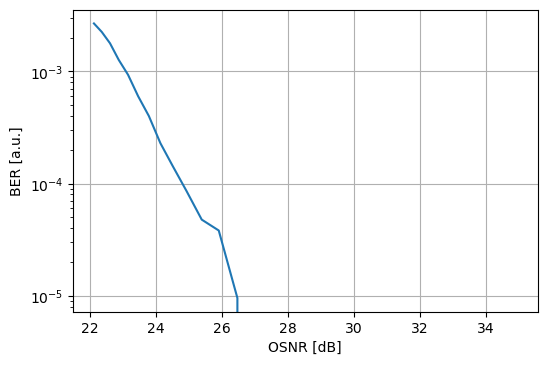

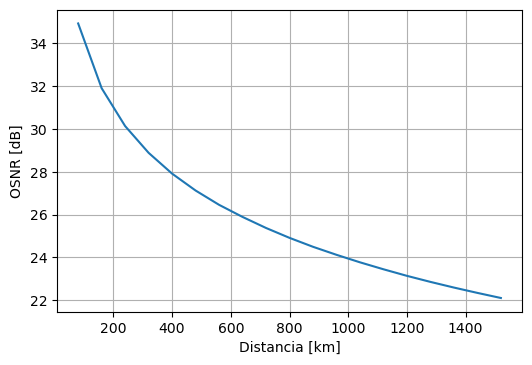

In [8]:
#Haciendo una curva de BER vs OSNR

spans=np.arange(1,20)
BER_l=[]
osnr_p=[]
Laser_mod_temp=Laser_mod
for ind in np.arange(0,len(spans)):
    #Parametros del amplificador
    #
    NoiseFigure=7 #Figura de Ruido [dB]
    Fn = 10**(NoiseFigure/10); # Noise figure linear

    Gain=16 #Ganancia dB para compensar una perdida de 80km
    G = 10**(Gain/10) # Ganancia linear

    #Simulando fibra solo con atenuacion
    
    att_db=0.2e-3 #Atenuacion en la fibra optica en [db/m]
    alpha=att_db*1e3*np.log(10)/10/1e3
    
    #Aplicando Att
    Laser_mod_temp=Laser_mod_temp*np.exp(80000*(-alpha/2))
    
    
    #Amplificacion sin ruido
    Laser_mod_temp = np.sqrt(G)*Laser_mod_temp

    #Ruido
    h   = 6.626076e-34 # Planck's constant [Js]
    BW  = 1/dt_samp;   # Bandwidth ode la senal
    S   = G*Fn*h*Frequencia_del_laser*1e3/2 # Power spectral density, [mW/Hz]
    P_n = S*BW #Potencia del Ruido
    # Creamos el ruido blanco en una señal compleja
    u_n = (np.sqrt(P_n)/np.sqrt(2))*(np.random.randn(len(Laser_mod_amp)) + 1j*np.random.randn(len(Laser_mod_amp)))
    #Agregamos el ruido a nuestra señal
    Laser_mod_temp = Laser_mod_temp + u_n;
   
    #OSNR
    #Medimos el OSNR
    #Potencia total:
    P_mean2 = np.mean(np.abs(Laser_mod_temp)**2)
    #Potencia de Ruido
    Noise2=np.fft.ifft(np.fft.fftshift(np.fft.fft(Laser_mod_temp))*Hf)
    P_noise_mean2 = np.mean(np.abs(Noise2)**2)/2


    osnr2=10*np.log10((P_mean2-P_noise_mean2*((Vector_frequencia_0[-1]-Vector_frequencia_0[0])/12.5e9))/P_noise_mean2)
    osnr_p.append(osnr2)
    
    print('OSNR='+str(osnr2))
    
    #Simulacion del Receptor

    Responsividad=1
    Ruido=0

    Rx_I=Responsividad*abs(Laser_mod_temp)**2

    noise = np.random.normal(0, Ruido, Rx_I.shape)
    Rx_I_noise = Rx_I + noise


    #Calculo del BER
    #Decisión entre 0 y 1:
    Limite = np.mean(Rx_I_noise)
    samples_per_bit=int(np.ceil(numero_de_muestras/len(bits)))
    spacing=int(np.ceil(samples_per_bit/2))    
    #Recuperacion del bit muestreando en el medio del bit
    bits_rx=Rx_I_noise[spacing:-1:samples_per_bit]
    #Decision entre 0 y 1
    bits_rx[bits_rx<=Limite]=0
    bits_rx[bits_rx>Limite]=1
    


    #Calculo del BER 
    BER=(len(bits_rx)-np.sum(bits_rx==bits[0:len(bits_rx)]))/len(bits_rx)
    print('Rx Power= '+str(np.round(10*np.log10(P_mean2),2))+ 'dBm BER ='+str(BER))
    BER_l.append(BER)

    
#Graficando BER vs Rx Power
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.grid(True)
plt.plot(osnr_p,BER_l)
plt.yscale('log')
plt.ylabel('BER [a.u.]')
plt.xlabel('OSNR [dB]')
plt.show()


#Graficando OSNR vs distancia
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.grid(True)
plt.plot(spans*80,osnr_p)
plt.ylabel('OSNR [dB]')
plt.xlabel('Distancia [km]')
plt.show()

